# Imports

In [1]:
!pip install fiftyone

In [2]:
import os
import numpy as np
import transformers
import fiftyone
from PIL import Image
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from typing import Tuple, List
from sklearn.model_selection import train_test_split



In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

# Data

In [4]:
dataset = fiftyone.zoo.load_zoo_dataset(
    "open-images-v7",
    max_samples=500,
    label_types=["classifications"],
    classes=["Cat", "Dog", "Car", "Tree", "Animal"],
)

Necessary images already downloaded
Existing download of split 'train' is sufficient
Necessary images already downloaded
Existing download of split 'test' is sufficient
Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading 'open-images-v7' split 'train'
 100% |█████████████████| 500/500 [2.0s elapsed, 0s remaining, 255.7 samples/s]      
Loading 'open-images-v7' split 'test'
 100% |█████████████████| 500/500 [513.5ms elapsed, 0s remaining, 973.7 samples/s]      
Loading 'open-images-v7' split 'validation'
 100% |█████████████████| 500/500 [719.0ms elapsed, 0s remaining, 695.4 samples/s]      
Dataset 'open-images-v7-500' created


Load and prepare your dataset. It should consist of at least 50k images from any openimages split.

In [5]:
dataset

Name:        open-images-v7-500
Media type:  image
Num samples: 1500
Persistent:  False
Tags:        []
Sample fields:
    id:              fiftyone.core.fields.ObjectIdField
    filepath:        fiftyone.core.fields.StringField
    tags:            fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    positive_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    negative_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)

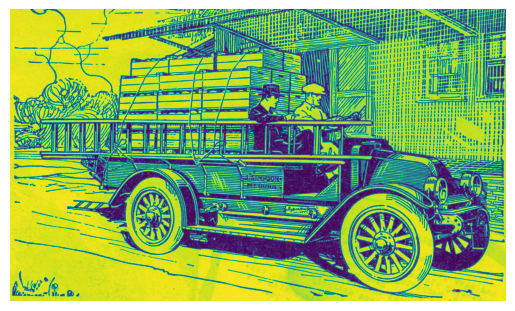

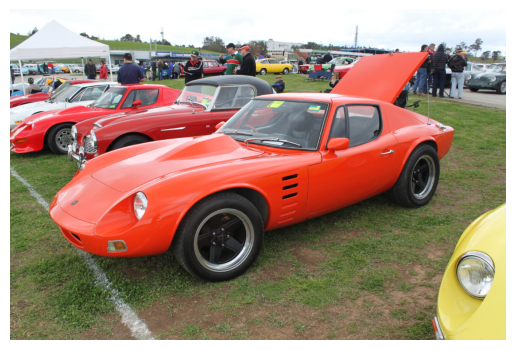

In [6]:
samples = dataset.take(2)

for sample in samples:
    image = Image.open(sample.filepath)
    plt.figure()
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()

In [7]:
def show_image(image):
    plt.figure(figsize=(15, 15))
    plt.imshow(image.numpy())
    plt.axis('off')
    plt.show()


# Display images in a grid
def show_images(images: list):
    plt.figure(figsize=(15, 15))

    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


# Image augmentation and crops

Implement image augmentation and crops as described in DINO.

In [8]:
class RandomGrayscale(tf.keras.layers.Layer):
    def __init__(self, probability=0.1, **kwargs):
        super(RandomGrayscale, self).__init__(**kwargs)
        self.probability = probability

    def call(self, inputs, training=None, **kwargs):
        def apply_grayscale():
            grayscale_image = tf.image.rgb_to_grayscale(inputs)
            return tf.image.grayscale_to_rgb(grayscale_image)

        random_numbers = tf.random.uniform([], minval=0, maxval=1)
        should_apply_grayscale = random_numbers < self.probability
        output = tf.cond(should_apply_grayscale, apply_grayscale, lambda: inputs)
        return output

    def get_config(self):
        config = super(RandomGrayscale, self).get_config()
        config.update({'probability': self.probability})
        return config

In [52]:
class DataAugmentationDINO:
    def __init__(self, global_crops_scale, local_crops_scale, global_crops_number=2, local_crops_number=4):
        self.global_crops_scale = global_crops_scale
        self.local_crops_scale = local_crops_scale
        self.global_crops_number = global_crops_number
        self.local_crops_number = local_crops_number

        self.flip_and_color_jitter = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomContrast(factor=0.25),
            tf.keras.layers.RandomBrightness(factor=0.3),
            tf.keras.layers.RandomRotation(factor=0.15),
            tf.keras.layers.GaussianNoise(stddev=0.1),
            RandomGrayscale(probability=0.2),
            tf.keras.layers.Rescaling(scale=1. / 255)

        ])

    def __call__(self, image) -> Tuple[List[Image], List[Image]]:
        
        global_crops = []
        for _ in range(self.global_crops_number):
            global_crop = self._random_resized_crop(image, size=224, scale=self.global_crops_scale)
            global_crop = self.flip_and_color_jitter(global_crop)
            global_crops.append(global_crop)

        local_crops = []
        for _ in range(self.local_crops_number):
            local_crop = self._random_resized_crop(image, size=224, scale=self.local_crops_scale)
        
            local_crop = self.flip_and_color_jitter(local_crop)
            local_crops.append(local_crop)

        return global_crops, local_crops

    @staticmethod
    def _random_resized_crop(image, size, scale):
        height, width = tf.cast(tf.shape(image)[0], tf.float32), tf.cast(tf.shape(image)[1], tf.float32)
        crop_height = tf.random.uniform(shape=[], minval=tf.cast((height * scale[0]), tf.int32),
                                        maxval=tf.cast((height * scale[1]), tf.int32), dtype=tf.dtypes.int32)
        crop_width = tf.random.uniform(shape=[], minval=tf.cast((width * scale[0]), tf.int32),
                                       maxval=tf.cast((width * scale[1]), tf.int32), dtype=tf.dtypes.int32)

        cropped_image = tf.image.random_crop(image, size=[crop_height, crop_width, 3])
        resized_image = tf.image.resize(cropped_image, [size, size])

        return resized_image

In [53]:
augmentor = DataAugmentationDINO((0.5, 0.6), (0.25, 0.5), 4, 4)

In [54]:
def extract_single_label(sample):
    # print(sample)
    return sample.positive_labels.classifications[0].label


filtered_samples = [sample for sample in dataset if sample.positive_labels.classifications]

filepaths = [sample.filepath for sample in filtered_samples]
labels = [extract_single_label(sample) for sample in filtered_samples]


def load_image(filepath, label):
    img = tf.io.read_file(filepath)
    # print(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, dtype=tf.int32)
    return img, label


def load_and_preprocess_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, dtype=tf.int32)
    global_crops, local_crops = augmentor(img)
    
    return (global_crops, local_crops), label


tf_dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels)).map(load_and_preprocess_image)

crop_test_tf_dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels)).map(load_image)

# print(tf_dataset)

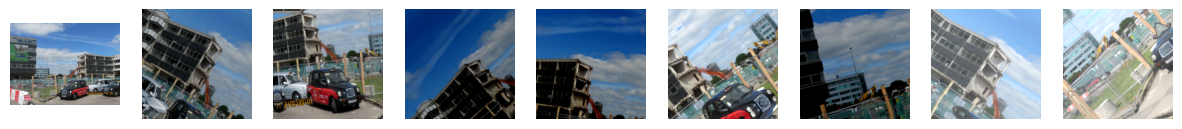

In [55]:
img = next(iter(crop_test_tf_dataset))[0]
global_crops, local_crops = augmentor.__call__(img)
show_images([img] + global_crops + local_crops)

# Losses

Implement the losses and loss additions. DINO, koleo, sinkhorn_knopp, softmax_centering.

In [48]:
# def dino_loss(student_output, teacher_output, temperature=0.1):
#     """
#     DINO loss function.
#     student_output: logits from the student network
#     teacher_output: logits from the teacher network (detached from gradients)
#     temperature: temperature scaling for the softmax function
#     """
#     student_probs = tf.nn.softmax(student_output / temperature, axis=-1)
#     teacher_probs = tf.nn.softmax(teacher_output / temperature, axis=-1)
#     loss = tf.reduce_mean(tf.keras.losses.kullback_leibler_divergence(teacher_probs, student_probs))
#     return loss

# Backbone

Implement a transformer model as described in DINO, including the DINO head. Don't forget the teacher weights update.

In [36]:
class DinoLoss(tf.keras.losses.Loss):
    def __init__(
            self,
            out_dim,
            teacher_temp,
            student_temp=0.1,
            center_momentum=0.9
    ):
        super().__init__()
        self.center = tf.Variable(tf.zeros(out_dim), trainable=False)
        self.student_temp = student_temp
        self.teacher_temp = teacher_temp
        self.center_momentum = center_momentum

    def call(self, teacher_output, student_output):
        teacher_out = tf.nn.l2_normalize(teacher_output - self.center, -1)
        student_out = tf.nn.l2_normalize(student_output, -1)
        loss = tf.reduce_mean(tf.reduce_sum(-teacher_out * tf.nn.log_softmax(student_out / self.student_temp, -1), -1))
        self.update_center(teacher_output)
        return loss

    def update_center(self, teacher_output):
        batch_center = tf.reduce_mean(teacher_output, axis=0)
        self.center.assign((self.center * self.center_momentum) + (batch_center * (1 - self.center_momentum)))

In [37]:
class DinoHead(tf.keras.models.Model):
    def __init__(
            self,
            input_dimension,
            out_dim,
            use_batch_normalization=False,
            norm_last_layer=True,
            layers_count=3,
    ):
        super(DinoHead, self).__init__()

        self.hidden_dim = 2048
        self.bottleneck_dim = 256

        self.input_dimension = input_dimension
        self.use_batch_normalization = use_batch_normalization
        self.out_dim = out_dim
        self.layers_count = layers_count

        self.norm_last_layer = norm_last_layer
        self.last_layer = tf.keras.layers.Dense(self.out_dim)

        self.mlp_block = self.mlp()

    def mlp(self):
        layers = [tf.keras.layers.Dense(self.hidden_dim, input_shape=(self.input_dimension,))]

        if self.use_batch_normalization:
            layers.append(tf.keras.layers.BatchNormalization())

        for _ in range(self.layers_count - 2):
            layers.append(tf.keras.layers.Dense(self.hidden_dim))

        if self.use_batch_normalization:
            layers.append(tf.keras.layers.BatchNormalization())

        layers.append(tf.keras.layers.ReLU())
        layers.append(tf.keras.layers.Dense(self.bottleneck_dim))
        return tf.keras.Sequential(layers)

    def call(self, input_tensor, mask=None, training=None):
        x = self.mlp_block(input_tensor, training)
        if self.norm_last_layer:
            x = tf.nn.l2_normalize(x, axis=-1)
        x = self.last_layer(x)
        return x

In [38]:
class Dino(tf.keras.Model):
    def __init__(self, teacher, student, loss):
        super().__init__()
        self.teacher = teacher
        self.student = student
        self.loss = loss

    def _forward(self, teacher_input, student_input):
        teacher_output = self.teacher(teacher_input, training=False)
        student_output = self.student(student_input, training=True)
        return teacher_output, student_output

    def train_step(self, data):
        teacher_input, student_input = data

        with tf.GradientTape() as tape:
            teacher_output, student_output = self._forward(teacher_input, student_input)
            loss = self.loss(teacher_output, student_output)

        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

        self.update_teacher_weights()

        self.compiled_metrics.update_state(teacher_output, student_output)

        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs, training=False, mask=None):
        if training:
            return self.student(inputs, training=True)
        else:
            return self.teacher(inputs, training=False)

    def update_teacher_weights(self):
        alpha = 0.9
        for teacher_param, student_param in zip(self.teacher.trainable_variables, self.student.trainable_variables):
            new_teacher_param = alpha * teacher_param + (1 - alpha) * student_param
            teacher_param.assign(new_teacher_param)


In [39]:
class HeadedBackbone(tf.keras.Model):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def call(self, inputs, training=False, mask=None):
        x = self.backbone(inputs, training=training)
        return self.head(x, training=training)

In [40]:
class Backbone(tf.keras.Model):
    def __init__(self):
        super(Backbone, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')

    def call(self, inputs, training=False, mask=None):
        x = self.conv1(inputs)
        x = self.pool(x)
        return self.dense1(x)

In [56]:
dino_head = DinoHead(input_dimension=128, out_dim=65536)
dino_loss = DinoLoss(out_dim=65536, teacher_temp=0.04, student_temp=0.1, center_momentum=0.9)

backbone = Backbone()
teacher = HeadedBackbone(backbone=backbone, head=dino_head)
student = HeadedBackbone(backbone=backbone, head=dino_head)

dino = Dino(teacher=teacher, student=student, loss=dino_loss)

# Training

Train the model as described in DINO.

In [57]:
# WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
ema_decay = 0.995
num_epochs = 10


def update_teacher_weights():
    for teacher_param, student_param in zip(teacher.trainable_variables, student.trainable_variables):
        teacher_param.assign(ema_decay * teacher_param + (1 - ema_decay) * student_param)


for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    for (global_crops_batch, local_crops_batch), _ in tqdm.tqdm(tf_dataset, desc=f"Epoch {epoch+1}/{num_epochs}"):
        with tf.GradientTape() as tape:
            student_input = tf.concat(global_crops_batch + local_crops_batch, axis=0)

            student_output = student(student_input, training=True)
            teacher_output = teacher(global_crops_batch, training=False)
            loss = dino_loss(teacher_output, student_output)

        gradients = tape.gradient(loss, student.trainable_variables)
        optimizer.apply_gradients(zip(gradients, student.trainable_variables))
        update_teacher_weights()
        epoch_loss_avg.update_state(loss)

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss_avg.result().numpy()}")


Epoch 1/10:   0%|          | 0/1464 [00:00<?, ?it/s]

Epoch 1, Loss: -2824.146484375


Epoch 2/10:   0%|          | 0/1464 [00:00<?, ?it/s]

Epoch 2, Loss: -2830.96533203125


Epoch 3/10:   0%|          | 0/1464 [00:00<?, ?it/s]

Epoch 3, Loss: -2830.441162109375


Epoch 4/10:   0%|          | 0/1464 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Evaluation

Show that features extracted by your model are similar for similar images and different for others.

# Bonus

Train a simple classification model on top of your extracted features on some simple dataset.